In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python import utils as putils

from matplotlib.lines import Line2D
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
%matplotlib notebook

In [3]:
# Set colors
visual_area, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params()


In [4]:
pl.rcParams['axes.labelsize']

16.0

# Dataset info

In [5]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### Responsive params
responsive_test = 'nstds' # 'nstds' #'ROC' #None
nstd_thr=10
responsive_thr = nstd_thr if responsive_test=='nstds' else 0.05 #0.05 #None
n_stds = None if responsive_test=='ROC' else 2.5 #None

response_type = 'dff'

response_str = '%s_%s-thr-%.2f' % (response_type, responsive_test, responsive_thr) 
print(response_str)

dff_nstds-thr-10.00


In [6]:
#### Create data ID for labeling figures with data-types
experiment = 'blobs'


# Output dir

In [7]:
#### Output dir
stats_dir = os.path.join(aggregate_dir, 'data-stats')

In [8]:
pupildir = os.path.join(aggregate_dir, 'behavior-state', 'pupil')
print(pupildir)

if not os.path.exists(pupildir):
    os.makedirs(pupildir)

/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/pupil


#### Get metadata for stimulus

In [9]:
experiment = 'blobs'

In [10]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
sdata['datakey'] = ['%s_%s_fov%i' % (session, animalid, fovnum) \
                        for session, animalid, fovnum in sdata[['session', 'animalid', 'fovnum']].values]

sdata[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

,animalid,session,fov
visual_area,,,
Li,26,26,26
Lm,22,22,22
V1,18,18,18


In [11]:
# Get blob metadata only - and only if have RFs
sdata_exp = pd.concat([g for k, g in sdata.groupby(['animalid', 'session', 'fov']) if 
                        (experiment in g['experiment'].values 
                         and ('rfs' in g['experiment'].values or 'rfs10' in g['experiment'].values)) ])

sdata_exp[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

,animalid,session,fov
visual_area,,,
Li,13,13,13
Lm,12,12,12
V1,11,11,11


#### Drop duplicates and whatnot fovs

In [12]:
stim_filterby = 'first'

if experiment=='blobs':
    has_gratings=False
    g_str = 'hasgratings' if has_gratings else 'blobsonly'
else:
    g_str = 'gratingsonly'
resp_filter_str = 'stim-filter-%s_%s_%s' % (stim_filterby, g_str, response_str)

In [13]:
# Drop duplicates and whatnot fovs
if experiment=='blobs':
    exp_dkeys = aggr.get_blob_datasets(filter_by=stim_filterby, has_gratings=has_gratings, as_dict=True)
elif experiment == 'gratings':
    exp_dkeys = aggr.get_gratings_datasets(filter_by=stim_filterby, as_dict=True)

dictkeys = [d for d in list(itertools.chain(*exp_dkeys.values()))]
stim_datakeys = ['%s_%s_fov%i' % (s.split('_')[0], s.split('_')[1], 
                   sdata[(sdata['animalid']==s.split('_')[1]) & (sdata['session']==s.split('_')[0])]['fovnum'].unique()[0]) for s in dictkeys]
expmeta = dict((k, [dv for dv in stim_datakeys for vv in v if vv in dv]) for k, v in exp_dkeys.items())

curr_sdata = sdata_exp[sdata_exp['datakey'].isin(stim_datakeys)].copy().reset_index(drop=True)
print('[%s] %i unique datakeys' % (experiment, len(stim_datakeys)))
curr_sdata[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

[blobs] 25 unique datakeys


,animalid,session,fov
visual_area,,,
Li,9,9,9
Lm,8,8,8
V1,8,8,8


In [14]:
#### Create data ID for labeling figures with data-types
data_id = '|'.join([traceid, resp_filter_str])
print(data_id)


traces001|stim-filter-first_blobsonly_dff_nstds-thr-10.00


In [15]:
curr_sdata.shape, sdata_exp.shape

((98, 7), (141, 7))

# Load gratings or blobs

In [16]:
#### Output dir
stats_dir = os.path.join(aggregate_dir, 'data-stats')

glob.glob(os.path.join(stats_dir, 'aggr_%s_trialmeans_*%s*_%s_stimulus.pkl' 
                                               % (experiment, responsive_test, response_type)))

['/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-15.00_dff_stimulus.pkl']

In [17]:
aggr_trialmeans_dfile = glob.glob(os.path.join(stats_dir, 
                                'aggr_%s_trialmeans_*%s*_%s_stimulus.pkl' 
                                               % (experiment, responsive_test, response_type)))[0]

print(aggr_trialmeans_dfile)
with open(aggr_trialmeans_dfile, 'rb') as f:
    MEANS = pkl.load(f)
    

/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl


In [18]:
# glob.glob(os.path.join(stats_dir, 'aggr_%s_trialmeans_*%s*_%s_baseline.pkl' 
#                                                % (experiment, responsive_test, response_type)))

In [19]:
# aggr_baselines_dfile = glob.glob(os.path.join(stats_dir, 
#                                 'aggr_%s_trialmeans_*%s*_%s_baseline.pkl'
#                                               % (experiment, responsive_test, response_type)))[0]

# print(aggr_baselines_dfile)
# with open(aggr_baselines_dfile, 'rb') as f:
#     BAS = pkl.load(f)

# Face tracker data

In [20]:
#### Set source/dst paths
dlc_home_dir = '/n/coxfs01/julianarhee/face-tracking'
dlc_project = 'facetracking-jyr-2020-01-25' #'sideface-jyr-2020-01-09'
dlc_project_dir = os.path.join(dlc_home_dir, dlc_project)

dlc_video_dir = os.path.join(dlc_home_dir, dlc_project, 'videos')
dlc_results_dir = os.path.join(dlc_project_dir, 'pose-analysis') # DLC analysis output dir

#### Training iteration info
dlc_projectid = 'facetrackingJan25'
scorer='DLC_resnet50'
iteration = 1
shuffle = 1
trainingsetindex=0
videotype='.mp4'
snapshot = 391800 #430200 #20900
DLCscorer = '%s_%sshuffle%i_%i' % (scorer, dlc_projectid, shuffle, snapshot)
print("Extracting results from scorer: %s" % DLCscorer)

Extracting results from scorer: DLC_resnet50_facetrackingJan25shuffle1_391800


#### Check which datakeys are missing DLC -- ALL data

In [21]:
print("Checking for existing results: %s" % dlc_results_dir)
dlc_runkeys = list(set([ os.path.split(f)[-1].split('DLC')[0] \
                       for f in glob.glob(os.path.join(dlc_results_dir, '*.h5'))]))
dlc_analyzed_experiments = ['_'.join(s.split('_')[0:4]) for s in dlc_runkeys]

# Get sdata indices that have experiments analyzed
ixs_wth_dlc = [i for i in sdata.index.tolist() 
                if '%s_%s' % (sdata.loc[i]['datakey'], sdata.loc[i]['experiment']) in dlc_analyzed_experiments]
dlc_dsets = sdata.iloc[ixs_wth_dlc]

dlc_datakeys = dlc_dsets['datakey'].unique()
sdata_datakeys = sdata['datakey'].unique()
print("%i of %i datasets with DLC." % (len(dlc_datakeys),len(sdata_datakeys)))


Checking for existing results: /n/coxfs01/julianarhee/face-tracking/facetracking-jyr-2020-01-25/pose-analysis
32 of 66 datasets with DLC.


In [22]:
glob.glob(os.path.join(dlc_project_dir, 'dlc-models', 'iteration-%i' % iteration,\
                      '%s-trainset95shuffle%i' % (dlc_projectid, shuffle), 'train', 'snapshot-%i.meta' % snapshot))


['/n/coxfs01/julianarhee/face-tracking/facetracking-jyr-2020-01-25/dlc-models/iteration-1/facetrackingJan25-trainset95shuffle1/train/snapshot-391800.meta']

#### Only include dsets with face-tracking

In [23]:
print("Checking for existing results: %s" % dlc_results_dir)
dlc_runkeys = list(set([ os.path.split(f)[-1].split('DLC')[0] \
                       for f in glob.glob(os.path.join(dlc_results_dir, '*.h5'))]))
dlc_analyzed_experiments = ['_'.join(s.split('_')[0:4]) for s in dlc_runkeys]

# Get sdata indices that have experiments analyzed
ixs_wth_dlc = [i for i in curr_sdata.index.tolist() 
                if '%s_%s' % (curr_sdata.loc[i]['datakey'], curr_sdata.loc[i]['experiment']) in dlc_analyzed_experiments]
dsets = curr_sdata.iloc[ixs_wth_dlc]

dlc_datakeys = dsets['datakey'].unique()
exp_datakeys = curr_sdata['datakey'].unique()
print("%i of %i datasets with DLC." % (len(dlc_datakeys),len(exp_datakeys)))
missing_dlc = [i for i in exp_datakeys if i not in dlc_datakeys]
print("Need %i datasets analyzed:" % len(missing_dlc), missing_dlc)

Checking for existing results: /n/coxfs01/julianarhee/face-tracking/facetracking-jyr-2020-01-25/pose-analysis
22 of 25 datasets with DLC.
('Need 3 datasets analyzed:', ['20190502_JC076_fov1', '20190617_JC097_fov1', '20190618_JC097_fov1'])


#### Loading existing extracted pupil data

In [24]:
bstate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state'
pupil_fpath = glob.glob(os.path.join(bstate_dir, '%s_pupil-traces_snapshot-%i.pkl' % (experiment, snapshot)))[0]
print(pupil_fpath)

# This is a dict, keys are datakeys
with open(pupil_fpath, 'rb') as f:
    PUPIL = pkl.load(f)

/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/blobs_pupil-traces_snapshot-391800.pkl


In [25]:
[i for i in exp_datakeys if '%s_%s' % (i, experiment) not in PUPIL.keys()]

['20190502_JC076_fov1', '20190617_JC097_fov1', '20190618_JC097_fov1']

# Load traces

In [26]:
from scipy import interpolate
def resample_traces(samples, in_rate=44.65, out_rate=20.0):

    n_in_samples= len(samples)
    in_samples = samples.copy() #[rid, :] #np.array(tracef['File%03d' % curr_file][trace_type][:])
    in_tpoints = np.arange(0, n_in_samples) #len(in_samples))

    n_out_samples = round(n_in_samples * out_rate/in_rate)
    #print("N out samples: %i" % n_out_samples)

    flinear = interpolate.interp1d(in_tpoints, in_samples, axis=0)

    out_tpoints = np.linspace(in_tpoints[0], in_tpoints[-1], n_out_samples)
    out_samples = flinear(out_tpoints)
    #print("Out samples:", out_samples.shape)
    
    return out_tpoints, out_samples

def resample_pupil_traces(pupiltraces, in_rate=20.0, out_rate=22.325, min_nframes=None):
    pupildfs = []
    if min_nframes is None:
        min_nframes = int(round(np.mean([len(g) for p, g in pupiltraces.groupby(['trial'])])))
    #print(min_nframes)
    for trial, g in pupiltraces.groupby(['trial']):
        if len(g['pupil']) < min_nframes:
            npad = min_nframes - len(g['pupil'])
            vals = np.pad(g['pupil'].values, pad_width=((0, npad)), mode='edge')
        else:
            vals = g['pupil'].values[0:min_nframes]
        #print(len(vals))
        _, out_s = resample_traces(vals, in_rate=in_rate, out_rate=out_rate)
        currconfig = g['config'].unique()[0]
        pupildfs.append(pd.DataFrame({'pupil': out_s, 
                                       'config': [currconfig for _ in np.arange(0, len(out_s))],
                                       'trial': [trial for _ in np.arange(0, len(out_s))]} ))
    pupildfs = pd.concat(pupildfs, axis=0).reset_index(drop=True)
    return pupildfs


def zscore_array(v):
    return (v-v.mean())/v.std()

# Select dataset (example FOV)

In [27]:
include_stimuli='all'

animalid = 'JC097'
session = '20190616'
fovnum = 1
datakey = '%s_%s_fov%i' % (session, animalid, fovnum)

if experiment == 'blobs':
    obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
else:
    obj = util.Gratings(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
sdf = obj.get_stimuli()
print(sdf.shape)

Creating blobs object [JC097|20190616|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
(50, 8)


In [28]:
all_configs = ['config%03d' % i for i in np.arange(1, sdf.shape[0]+1)]
if experiment=='blobs':
    control_configs = ['config001', 'config002', 'config003', 'config004', 'config005']
elif experiment=='gratings':
    control_configs = sdf[sdf['size']>100].index.tolist()
    
if include_stimuli=='fullscreen':
    included_configs = [c for c in all_configs if c in control_configs]
elif include_stimuli=='image':
    included_configs = [c for c in all_configs if c not in control_configs]
elif include_stimuli=='all':
    included_configs = all_configs
else:
    print("UNKNOWN: %s" % include_stimuli)
print("Restricting stimuli to: %s (%i conditions)" % (include_stimuli, len(included_configs)))

Restricting stimuli to: all (50 conditions)


In [29]:
# Get neural means
print(datakey)
neuraldf = MEANS[datakey].copy()
print(neuraldf.shape)

# Get pupil traces
pupiltraces = PUPIL['%s_%s' % (datakey, experiment)].copy()
pupiltraces.head()


20190616_JC097_fov1
(1500, 297)


,config,pupil,trial
0,config004,33.363709,1
1,config004,33.359263,1
2,config004,33.837850,1
3,config004,34.106828,1
4,config004,29.055174,1


# Downsample and align traces

In [30]:
print("Loading <%s> traces: test=%s, thr=%.3f" % (response_type, responsive_test, responsive_thr))


Loading <dff> traces: test=nstds, thr=10.000


In [31]:
print("Loading <%s> traces: test=%s, thr=%.3f" % (response_type, responsive_test, responsive_thr))

#### Load traces of responsive cells
traces, labels, sdf = aggr.load_traces(animalid, session, fovnum, experiment, traceid=traceid, 
                                         response_type=response_type,
                                         responsive_test=responsive_test, 
                                         responsive_thr=responsive_thr)
trial_key = dict((int(t[5:]), g['config'].unique()[0]) for t, g in labels.groupby(['trial']))
roi_list = traces.columns.tolist()

Loading <dff> traces: test=nstds, thr=10.000
Creating blobs object [JC097|20190616|FOV1_zoom2p0x|traces001]
... exp.load()
... loading saved data array (dff).
... updating self
... getting responsive cells (test: nstds, thr: 10.00')
... loading stats
296 of 432 cells responsive


In [32]:
# Get trial alignment info
alignment_info = aggr.get_trial_alignment(animalid, session, fovnum, experiment, traceid=traceid)
alignment_info

{u'align_traces': True,
 u'append_trace_type': False,
 u'create_new': False,
 u'do_neuropil_correction': True,
 u'iti_post': u'1.0',
 u'iti_pre': u'1.0',
 u'ncores': 2,
 u'nonnegative': True,
 u'np_correction_factor': u'0.7',
 u'np_niterations': u'20',
 u'plot_psth': False,
 u'quantile': 0.10000000000000001,
 u'raw_only': True,
 u'save_warp_images': True,
 u'session': u'20190616',
 u'slurm': True,
 u'window_size_sec': 30.0}

In [33]:
# Temporal binning params
new_framerate = 20.0
framerate = 44.65

#n_frames_bin = np.ceil(framerate/new_framerate) #11.
#new_framerate = (framerate/n_frames_bin)
print("Downsampled fr: %.2f Hz" % new_framerate)


#### Get trial epochs
stim_on = float(labels['stim_on_frame'].unique())
n_on = float(labels['nframes_on'].unique())
iti_pre = float(alignment_info['iti_pre'])
iti_post = float(alignment_info['iti_post'])
stim_dur = stim_on/framerate

#### Get indices of trial epochs to model
pre_flank = round((iti_pre)*44.65) #n_on/2.
post_flank = round((iti_post)*44.65)  #n_on

# start_ix = int(stim_on-pre_flank)
# end_ix = int(stim_on + n_on + post_flank + 1)
# print(start_ix, end_ix, end_ix-start_ix)


Downsampled fr: 20.00 Hz


In [34]:
rid=90
# Create trial mat, downsampled: shape = (ntrials, nframes_per_trial)
trialmat = pd.DataFrame(np.vstack([traces[rid][tg.index] for trial, tg in labels.groupby(['trial'])]),\
                        index=[int(trial[5:]) for trial, tg in labels.groupby(['trial'])])
configs_on_included_trials = [tg['config'].unique()[0] for trial, tg in labels.groupby(['trial'])]
included_trials = [trial for trial, tg in labels.groupby(['trial'])]

#### Bin traces - Each tbin is a column, each row is a sample 
sample_data = trialmat.fillna(method='pad').copy()
sample_data.shape

(1500, 135)

In [35]:
#### Get resampled indices of trial epochs
nframes_per_trial = sample_data.shape[1]
print("%i frames/trial" % nframes_per_trial)
out_tpoints, out_ixs = resample_traces(np.arange(0, nframes_per_trial), in_rate=framerate, out_rate=new_framerate)
new_stim_on = int(np.where(abs(out_ixs-stim_on) == min(abs(out_ixs-stim_on)))[0])
print(new_stim_on)
new_n_on = int(round( stim_dur*new_framerate))
print(new_n_on)


135 frames/trial
20
20


In [36]:
#### Bin traces - Each tbin is a column, each row is a sample 
df = trialmat.fillna(method='pad').copy().T
xdf = df.reindex(df.index.union(out_ixs)).interpolate('values').loc[out_ixs]
binned_trialmat = xdf.T
n_tbins = binned_trialmat.shape[1]
# binned_trialmat = sample_data.T.groupby(np.arange(len(sample_data.columns))//n_frames_bin, axis=0).mean().T
# n_tbins = np.ceil(trialmat.shape[1] / n_frames_bin)

#### Zscore traces 
zscored_neural = binned_trialmat / binned_trialmat.values.ravel().std()

# Reshape roi traces
cfg_list = np.hstack([[c for _ in np.arange(0, n_tbins)] for c in configs_on_included_trials])
r_ = zscored_neural.T.unstack().reset_index() # level_0=trial number, level_1=frame number
r_.rename(columns={'level_0': 'trial', 'level_1': 'frame_ix', 0: rid}, inplace=True)
r_['config'] = cfg_list
#r_list.append(r_)

print(trialmat.shape, binned_trialmat.shape)


((1500, 135), (1500, 60))


### Test traces

In [37]:
included_trial_nums = sorted(pupiltraces['trial'].unique())

# Check with known config, known RID
ml=40 #-1
sz=20
#print(sdf[(sdf['morphlevel']==ml) & (sdf['size']==sz)])
cfg = sdf[(sdf['morphlevel']==ml) & (sdf['size']==sz)].index[0]
trial_ixs_currcfg = np.array([int(t[5:]) for t in labels[labels['config']==cfg]['trial'].unique()])
trial_ixs = np.array([t for t in trial_ixs_currcfg if t in included_trial_nums])
print("[%s] plotting %i of %i trials" % (cfg, len(trial_ixs), len(trial_ixs_currcfg)))

[config022] plotting 30 of 30 trials


((1500, 135), (1500, 60))


<IPython.core.display.Javascript object>


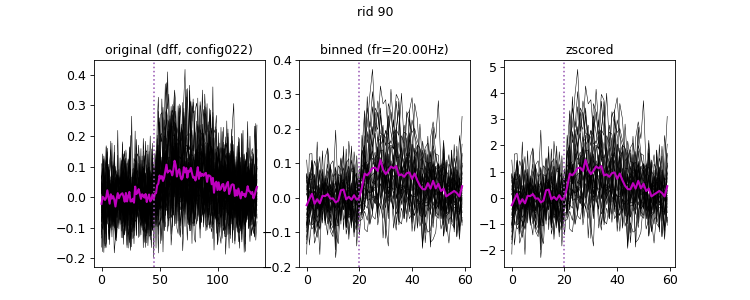

Text(0.5,0.98,u'rid 90')

In [38]:
print(trialmat.shape, binned_trialmat.shape)
#raw_ = trialmat.loc[included_trial_nums].copy()
#binned_ = binned_trialmat.loc[included_trial_nums].copy()
#zscored_ = zscored_neural.loc[included_trial_nums].copy()

fig, axn = pl.subplots(1, 3, figsize=(10,4))
ax=axn[0]; ax.set_title('original (%s, %s)' % (response_type, cfg));
ax.plot(trialmat.loc[trial_ixs].values.T, 'k', lw=0.5)
ax.plot(np.nanmean(trialmat.loc[trial_ixs].values.T, axis=1), 'm', lw=2)
ax.axvline(x=stim_on, ls=':')

ax=axn[1]; ax.set_title('binned (fr=%.2fHz)' % (new_framerate));
ax.plot(binned_trialmat.loc[trial_ixs].values.T, 'k', lw=0.5)
ax.plot(np.nanmean(binned_trialmat.loc[trial_ixs].values.T, axis=1), 'm', lw=2)
ax.axvline(x=new_stim_on, ls=':')


ax=axn[2]; ax.set_title('zscored');
ax.plot(zscored_neural.loc[trial_ixs].values.T, 'k', lw=0.5)
ax.plot(np.nanmean(zscored_neural.loc[trial_ixs].values.T, axis=1), 'm', lw=2)
ax.axvline(x=new_stim_on, ls=':')
pl.subplots_adjust(top=0.8)
pl.suptitle('rid %i' % rid)


#### Match pupil framerate

In [39]:
len(out_ixs)

60

In [40]:
print(new_framerate)
#### Resample pupil
desired_nframes = len(out_ixs) # 60
binned_pupil = resample_pupil_traces(pupiltraces, in_rate=20.0, out_rate=new_framerate, 
                                     min_nframes=desired_nframes)


pupil_trialmat = pd.DataFrame(np.vstack([p['pupil'].values for trial, p in binned_pupil.groupby(['trial'])]),
                              index=binned_trialmat.index, columns=binned_trialmat.columns)
print(pupil_trialmat.shape)


20.0
(1500, 60)


<IPython.core.display.Javascript object>


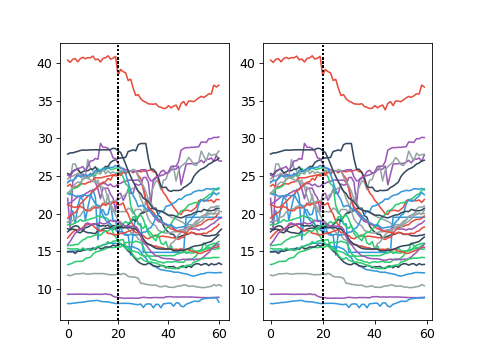

In [41]:
fig, axn = pl.subplots(1, 2)
ax=axn[0]
for t, pg in pupiltraces[pupiltraces['config']==cfg].groupby(['trial']):
    ixs = np.arange(0, len(pg['pupil'].values))
    ax.plot(ixs, pg['pupil'].values)
    ax.axvline(x=new_stim_on, ls=':', color='k')
    
ax=axn[1]
for t, pg in binned_pupil[binned_pupil['config']==cfg].groupby(['trial']):
    ixs = np.arange(0, len(pg['pupil'].values))
    ax.plot(ixs, pg['pupil'].values)
    ax.axvline(x=new_stim_on, ls=':', color='k')

<IPython.core.display.Javascript object>


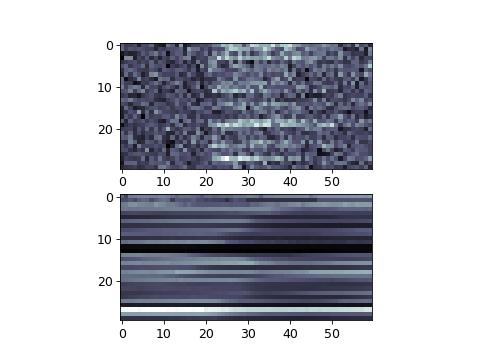

In [42]:
fig, axn = pl.subplots(2, 1)
ax=axn[0]
ax.imshow(binned_trialmat.loc[trial_ixs], cmap='bone')
ax=axn[1]
ax.imshow(pupil_trialmat.loc[trial_ixs], cmap='bone')


# Get all rois and traces

In [43]:
pupil_r = pupil_trialmat.T.unstack().reset_index().rename(columns={'level_0': 'trial', 
                                                                   'level_1': 'frame',
                                                                   0: 'pupil'})
print(pupil_r.shape)



(90000, 3)


In [44]:
r_list=[]
#rid=90
for rid in roi_list:
    # Create trial mat, downsampled: shape = (ntrials, nframes_per_trial)
    trialmat = pd.DataFrame(np.vstack([traces[rid][tg.index] for trial, tg in labels.groupby(['trial'])]),\
                            index=[int(trial[5:]) for trial, tg in labels.groupby(['trial'])])
    configs_on_included_trials = [tg['config'].unique()[0] for trial, tg in labels.groupby(['trial'])]
    included_trials = [trial for trial, tg in labels.groupby(['trial'])]


    #### Bin traces - Each tbin is a column, each row is a sample 
#     sample_data = trialmat.fillna(method='pad').copy()
#     binned_trialmat = sample_data.T.groupby(np.arange(len(sample_data.columns))//n_frames_bin, axis=0).mean().T
#     n_tbins = np.ceil(trialmat.shape[1] / n_frames_bin)
    df = trialmat.fillna(method='pad').copy().T
    xdf = df.reindex(df.index.union(out_ixs)).interpolate('values').loc[out_ixs]
    binned_trialmat = xdf.T # should be Ntrials # Nframes
    n_tbins = binned_trialmat.shape[1]

    #### Zscore traces 
    zscored_neural = binned_trialmat / binned_trialmat.values.ravel().std()

    # Reshape roi traces
    cfg_list = np.hstack([[c for _ in np.arange(0, n_tbins)] for c in configs_on_included_trials])
    r_ = zscored_neural.T.unstack().reset_index() # level_0=trial number, level_1=frame number
    r_.rename(columns={'level_0': 'trial', 'level_1': 'frame_ix', 0: rid}, inplace=True)
    r_list.append(r_)

# Create trial mat, downsampled: shape = (ntrials, nframes_per_trial)
trialmat = pd.DataFrame(np.vstack([traces[rid][tg.index] for trial, tg in labels.groupby(['trial'])]),\
                        index=[int(trial[5:]) for trial, tg in labels.groupby(['trial'])])
configs_on_included_trials = [tg['config'].unique()[0] for trial, tg in labels.groupby(['trial'])]
included_trials = [trial for trial, tg in labels.groupby(['trial'])]


traces_r = pd.concat(r_list, axis=1)
print(r_.shape, traces_r.shape)
traces_r['config'] = cfg_list

_, dii = np.unique(traces_r.columns, return_index=True)
traces_r = traces_r.iloc[:, dii]
print(traces_r.shape)


KeyboardInterrupt: 

#### Sort ROIs by correlation w/ pupil (for visualization)

In [176]:
pupil_values = pupil_r.sort_values(by=['trial', 'frame'])['pupil'].values

pupilcorrs = [np.corrcoef(traces_r.sort_values(by=['trial', 'frame_ix'])[rid], pupil_values)[0, 1] for rid in roi_list]


In [177]:
sorted_ixs = np.argsort(pupilcorrs)
# for ri in sorted_ixs:
#     print(ri, roi_list[ri], pupilcorrs[ri])
sorted_rids = np.array([roi_list[ri] for ri in sorted_ixs[::-1]])

In [178]:
# from matplotlib.colors import LinearSegmentedColormap

# cmap_name='nic_edge'
# cmap_dir='/n/coxfs01/julianarhee/aggregate-visual-areas/colormaps'

# #colormap = 'nic_Edge'
# #cmapdir = os.path.join(aggr_dir, 'colormaps')
# cdata = np.loadtxt(os.path.join(cmap_dir, cmap_name) + ".txt")
# cmap = LinearSegmentedColormap.from_list('my_colormap', cdata) #[::-1])
cmap='seismic'

In [179]:
new_stim_on, new_n_on

(20, 20)

In [180]:
on_frames = np.arange(new_stim_on, new_stim_on+new_n_on)
print(len(on_frames))
on_frames


20


array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39])

In [189]:
pupil_r['frame_int'] = [int(round(f)) for f in pupil_r['frame']]
interp_frame_ixs = list(sorted(pupil_r['frame'].unique()))
pupil_r['frame_ix'] = [interp_frame_ixs.index(f) for f in pupil_r['frame']]


In [181]:
trial_ixs = sorted(pupil_r['trial'].unique())

<IPython.core.display.Javascript object>


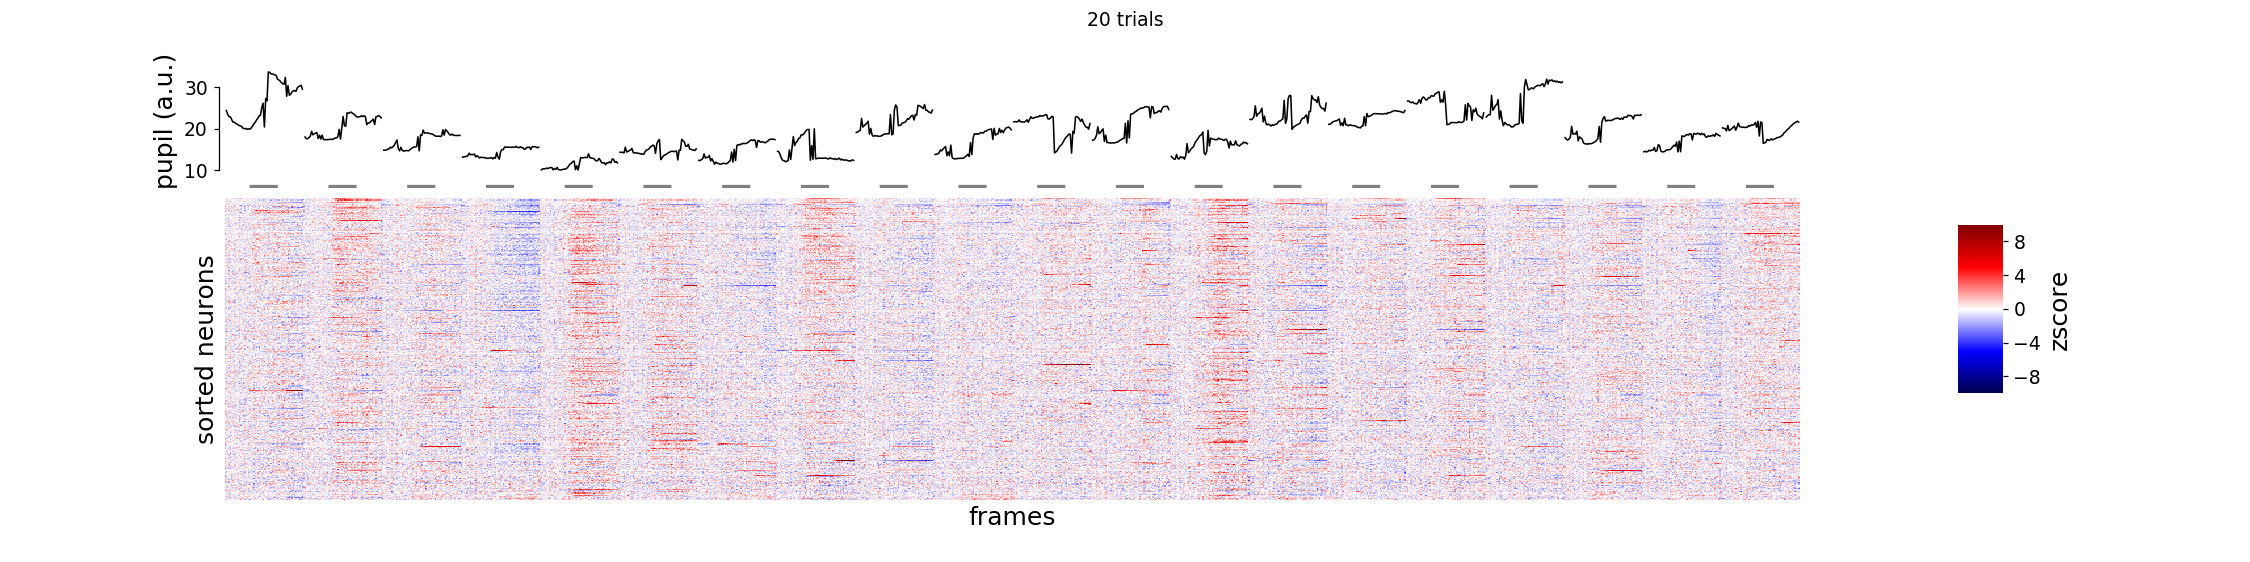

('/n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/pupil', 'sorted_neurons_pupil_trace_20trials_bin20fHz')


In [192]:
ntrials_plot = 20
start_trial = 1200
pupil_lw=1
stim_lw=2

curr_trial_ixs = trial_ixs[start_trial:start_trial+ntrials_plot]
curr_pupil_trace = pupil_r[pupil_r['trial'].isin(curr_trial_ixs)].sort_values(by='trial')['pupil'].values
stim_ixs = [1 if f in on_frames else np.nan for f in pupil_r[pupil_r['trial'].isin(curr_trial_ixs)]['frame_ix']]

curr_p = pupil_r[pupil_r['trial'].isin(curr_trial_ixs)].copy()
ix = curr_p.index.tolist()
on_ixs_global = [ix.index(i) for i in curr_p[curr_p['frame']==0].index.tolist()]
pvs = curr_pupil_trace.copy()
pvs[on_ixs_global] = np.nan

#fig, ax = pl.subplots()
grid_kws = {"height_ratios": (.25, 0.05, .7), "hspace": .005}
fig, (ax1, stimax, ax0) = pl.subplots(3,1, gridspec_kw=grid_kws, figsize=(20,5), dpi=dpi, sharex=True)

cbar_ax = fig.add_axes([.87, .3, .02, .3])
#im0 = ax.imshow(traces_r[roi_list].T, cmap='bone', aspect=200, vmin=-10, vmax=10)
#pl.colorbar(im0, ax=ax)
im0 = sns.heatmap(traces_r[traces_r['trial'].isin(curr_trial_ixs)][sorted_rids].T, ax=ax0,
                  cmap=cmap, center=0, vmin=-10, vmax=10,
                  cbar_ax=cbar_ax, cbar_kws={'label': 'zscore'})
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_ylabel('sorted neurons')
ax0.set_xlabel('frames')
             
nframes_total=len(pupil_r)
#divider = make_axes_locatable(ax)
#topax = divider.append_axes("top", 1.2, pad=0.5, sharex=None) #scatterax) #None)
ax1.plot(np.arange(0, len(curr_pupil_trace)), pvs, lw=pupil_lw, color='k')
ax1.set_ylabel('pupil (a.u.)')
#ax1.set_ylim([0, 50])

stimax.plot(np.arange(0, len(curr_pupil_trace)), stim_ixs, color='gray', lw=stim_lw)
stimax.tick_params(which='both', axis='both', size=0)
stimax.axis('off')


sns.despine(trim=True, bottom=True, ax=ax1, offset=4)
ax1.tick_params(axis='x', which='both', size=0)
ax1.set_xticks([])
pl.subplots_adjust(left=0.1, right=0.8)
fig.suptitle('%i trials' % ntrials_plot)


figname = 'sorted_neurons_pupil_trace_%itrials_bin%ifHz' % (ntrials_plot, new_framerate)
pl.savefig(os.path.join(pupildir, '%s.png' % figname))
print(pupildir, figname)

In [193]:
print(traces_r.shape, pupil_r.shape)
traces_r.head()


((90000, 299), (90000, 5))


,0,1,2,3,4,5,6,7,8,9,...,421,422,423,424,425,426,431,config,frame_ix,trial
0,0.184304,0.443776,0.101527,0.334589,-0.120514,-0.030210,0.834548,-1.107893,0.727642,0.482937,...,1.031262,-0.686322,1.036999,0.857312,0.262095,0.603493,0.316486,config004,0.000000,1
1,-0.496884,-1.278281,0.119737,-0.882493,0.620354,0.414988,-0.583668,-0.442248,-0.221285,-1.302858,...,-0.208142,-0.806933,-0.373219,-1.219070,-0.130620,0.945848,-0.037501,config004,2.271186,1
2,0.111335,0.481243,0.461598,-0.575738,-0.627820,0.197481,0.111907,-0.641268,0.390237,-0.839174,...,-0.347444,0.268511,-1.303407,-0.382167,-0.978617,1.209853,-0.380543,config004,4.542373,1
3,0.351031,0.585230,0.229904,0.330824,-0.274369,1.374529,-1.412427,-0.193406,-1.579748,1.305174,...,0.323642,-0.918050,0.848906,-0.892719,-0.400818,0.372830,-0.701054,config004,6.813559,1
4,0.859481,-0.164270,0.398303,0.877019,-0.926989,0.804197,-0.013329,0.276446,-0.228122,-1.600152,...,0.244412,-0.457650,-0.980043,0.123547,-0.722893,-0.849886,0.875485,config004,9.084746,1


# Create data frames for pupil/neural data - test low/high pupil

In [54]:
# neuraldf = pd.concat([g[roi_list].mean(axis=0) for t, g in traces_r.groupby(['trial'])], axis=1).T
# print(neuraldf.shape)
# config_list = [g['config'].unique()[0] for t, g in traces_r.groupby(['trial'])]
print(datakey)
neuraldf=MEANS[datakey].copy()

20190616_JC097_fov1


In [55]:
pupildf = pd.concat([g.mean(axis=0) for t, g in pupil_r.groupby(['trial'])], axis=1).T
print(pupildf.shape)

pupil_quantiles = pupildf.pupil.quantile([0.25,0.5,0.75])

(1500, 3)


<IPython.core.display.Javascript object>


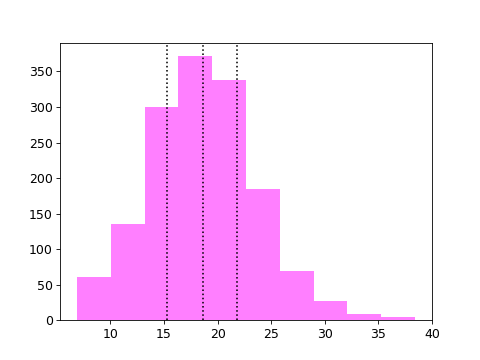

In [56]:
fig, ax = pl.subplots()
ax.hist(pupildf['pupil'], color='magenta', alpha=0.5)
for v in pupil_quantiles:
    ax.axvline(x=v, ls=':', color='k')

<IPython.core.display.Javascript object>


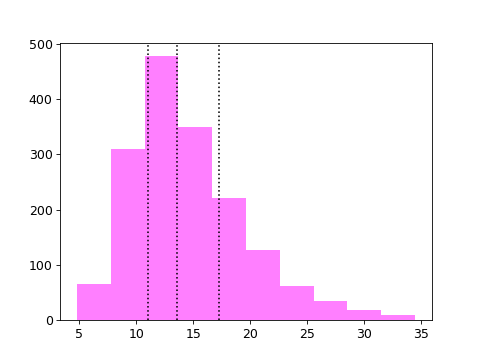

In [180]:
pupil_quantiles = pupildf.pupil.quantile([0.25,0.5,0.75])

fig, ax = pl.subplots()
ax.hist(pupildf['pupil'], color='magenta', alpha=0.5)
for v in pupil_quantiles:
    ax.axvline(x=v, ls=':', color='k')

## Subdivide pupil levels into high/low

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

import scipy.stats as spstats
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler

import sklearn.metrics as skmetrics

In [57]:
import sklearn.metrics as skmetrics
import random

def computeMI(x, y):
    sum_mi = 0.0
    x_value_list = np.unique(x)
    y_value_list = np.unique(y)
    Px = np.array([ len(x[x==xval])/float(len(x)) for xval in x_value_list ]) #P(x)
    Py = np.array([ len(y[y==yval])/float(len(y)) for yval in y_value_list ]) #P(y)
    for i in xrange(len(x_value_list)):
        if Px[i] ==0.:
            continue
        sy = y[x == x_value_list[i]]
        if len(sy)== 0:
            continue
        pxy = np.array([len(sy[sy==yval])/float(len(y))  for yval in y_value_list]) #p(x,y)
        t = pxy[Py>0.]/Py[Py>0.] /Px[i] # log(P(x,y)/( P(x)*P(y))
        sum_mi += sum(pxy[t>0]*np.log2( t[t>0]) ) # sum ( P(x,y)* log(P(x,y)/( P(x)*P(y)) )
    return sum_mi

In [67]:
def fit_svm(curr_data, sdf, m0=0, m100=106, C_value=1.0, n_iterations=100):
    iter_results=[]
    iter_results_chance=[]
    for iteration in np.arange(0, n_iterations):

        #### Select train/test configs for clf A vs B
        object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
        curr_roi_list = [int(c) for c in curr_data.columns if c != 'config']
        sample_data = curr_data[curr_data['config'].isin(object_configs)]

        #### Equalize df/f across neurons:  Normalize each neuron to have same (zero) mean, (unit) SD across stimuli
        data = sample_data[curr_roi_list]
        zdata = (data - data.mean()) / data.std()

        #### Get labels
        targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])
        targets['label'] = [sdf['morphlevel'][cfg] for cfg in targets['config'].values]
        targets['group'] = [sdf['size'][cfg] for cfg in targets['config'].values]

        stimdf = sdf[sdf['morphlevel'].isin([m0, m100])]
        sizes = sorted(stimdf['size'].unique())

        #### For each transformation, split trials into 80% and 20%
        train_data=[]; test_data=[]; 
        train_labels=[]; test_labels=[]; 
        train_data_chance=[]; test_data_chance=[]; 
        train_labels_chance=[]; test_labels_chance=[]; 
        train_data, test_data, train_labels, test_labels = train_test_split(zdata, targets['label'].values, 
                                                            test_size=0.2, stratify=targets['group'])

#         for sz in sizes: 
#             curr_configs = sdf[sdf['size']==sz].index.tolist()
#             curr_trials = np.array(targets[targets['config'].isin(curr_configs)].index.tolist())
#             xi = zdata.loc[curr_trials]
#             yi = targets.loc[curr_trials]['label'].values

#             # Split train/test
#             train_x, test_x, train_y, test_y = train_test_split(xi, yi, test_size=0.2, startify=)
#             train_data.append(train_x)
#             test_data.append(test_x)
#             train_labels.append(train_y)
#             test_labels.append(test_y)
#         # Aggregate TRAIN/TEST data   
#         train_data = np.vstack(train_data)
#         train_labels = np.hstack(train_labels)
#         test_data = np.vstack(test_data)
#         test_labels = np.hstack(test_labels)

        #### DATA - Fit classifier
        scaler = StandardScaler()
        scaler.fit(train_data)
        train_data = scaler.transform(train_data)
        svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
        scores = cross_validate(svc, train_data, train_labels, cv=5,
                                scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                return_train_score=True)
        iterdict = dict((s, values.mean()) for s, values in scores.items())

        #### DATA - Test with held-out data
        test_data = scaler.transform(test_data)
        trained_svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels)
        test_score = trained_svc.score(test_data, test_labels)

        #### DATA - Calculate MI
        predicted_labels = trained_svc.predict(test_data)
        mi = skmetrics.mutual_info_score(test_labels, predicted_labels)
        ami = skmetrics.adjusted_mutual_info_score(test_labels, predicted_labels)
        log2_mi = computeMI(test_labels, predicted_labels)

        iterdict.update({'heldout_test_score': test_score, 
                         'heldout_MI': mi, 'heldout_aMI': ami, 'heldout_log2MI': log2_mi})
        iter_results.append(pd.DataFrame(iterdict, index=[iteration]))

        # ------------------------------------------------------------------
        # Shuffle LABELS to calculate chance level
        train_labels_chance = train_labels.copy()
        np.random.shuffle(train_labels_chance)
        test_labels_chance = test_labels.copy()
        np.random.shuffle(test_labels_chance)

        #### CHANCE - Fit classifier
        svc_chance = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
        scores_chance = cross_validate(svc, train_data, train_labels_chance, cv=5,
                                scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                return_train_score=True)
        iterdict_chance = dict((s, values.mean()) for s, values in scores_chance.items())

        # CHANCE - Test with held-out data
        trained_svc_chance = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels_chance)
        test_score_chance = trained_svc_chance.score(test_data, test_labels_chance)  

        # Chance - Calculate MI
        predicted_labels = trained_svc_chance.predict(test_data)
        mi = skmetrics.mutual_info_score(test_labels, predicted_labels)
        ami = skmetrics.adjusted_mutual_info_score(test_labels, predicted_labels)
        log2_mi = computeMI(test_labels, predicted_labels)

        iterdict_chance.update({'heldout_test_score': test_score_chance, 
                                'heldout_MI': mi, 'heldout_aMI': ami, 'heldout_log2MI': log2_mi})
        iter_results_chance.append(pd.DataFrame(iterdict_chance, index=[iteration]))

    # DATA - get mean across iters
    df = pd.concat(iter_results, axis=0)
    df_chance = pd.concat(iter_results_chance, axis=0)
    
    return df, df_chance


In [68]:
low_pupil_thr = pupil_quantiles[0.25]
high_pupil_thr = pupil_quantiles[0.75]

pupil_low = pupildf[pupildf['pupil']<low_pupil_thr].copy()
pupil_high = pupildf[pupildf['pupil']>high_pupil_thr].copy()

# Get trial indices of low/high pupil 
low_trial_ixs = sorted(pupil_low['trial'].unique())
high_trial_ixs = sorted(pupil_high['trial'].unique())

#print(pupil_low.shape, pupil_high.shape)


In [69]:
m0=0
m100=106
C_value=1

n_iterations = 50

In [70]:
curr_data = neuraldf.copy()
df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)

# Fit LOW
curr_data = neuraldf.loc[low_trial_ixs].copy()
lo, lo_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)


# Fit HIGH
curr_data = neuraldf.loc[high_trial_ixs].copy()
hi, hi_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)


In [71]:
df.head()

,fit_time,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,score_time,test_accuracy,test_neg_mean_squared_error,test_r2,train_accuracy,train_neg_mean_squared_error,train_r2
0,0.015195,0.224060,0.315042,0.323250,0.816667,0.006101,0.729818,-3035.765053,-0.083456,1.0,0.0,1.0
1,0.017075,0.155084,0.214741,0.223740,0.766667,0.001367,0.695994,-3415.807425,-0.216420,1.0,0.0,1.0
2,0.014378,0.174966,0.243271,0.252423,0.783333,0.000947,0.742396,-2894.440925,-0.030623,1.0,0.0,1.0
3,0.014903,0.120973,0.164342,0.174527,0.733333,0.001053,0.774436,-2534.442510,0.097565,1.0,0.0,1.0
4,0.020157,0.153881,0.218683,0.222003,0.783333,0.004729,0.725736,-3081.626277,-0.099844,1.0,0.0,1.0


In [72]:
metric='heldout_test_score'
print("all: %.2f (chance=%.2f)" % (df.mean()[metric], df_chance.mean()[metric]))
print("low: %.2f (chance=%.2f)" % (lo.mean()[metric], lo_chance.mean()[metric]))
print("high: %.2f (chance=%.2f)" % (hi.mean()[metric], hi_chance.mean()[metric]))


all: 0.75 (chance=0.51)
low: 0.58 (chance=0.49)
high: 0.67 (chance=0.47)


In [73]:
desired_nframes = 60 #len(out_ixs) # 60
binned_pupil = resample_pupil_traces(pupiltraces, in_rate=20.0, out_rate=new_framerate, 
                                     min_nframes=desired_nframes)
trials_ = sorted(pupiltraces['trial'].unique())
frames_ = np.arange(0, desired_nframes)
#     binned_pupil = resample_pupil_traces(pupiltraces, in_rate=20.0, out_rate=new_framerate)
#     # binned_trialmat.shape # Ntrials # Nframes
#     trials_ = sorted(pupiltraces['trial'].unique())
#     new_nframes_per_trial = binned_pupil.shape[0]/float(len(trials_))
#     frames_ = np.arange(0, new_nframes_per_trial)
pupil_trialmat = pd.DataFrame(np.vstack([p['pupil'].values for trial, p in binned_pupil.groupby(['trial'])]),
                              index=trials_, columns=frames_)
                              #index=binned_trialmat.index, columns=binned_trialmat.columns)
pupil_r = pupil_trialmat.T.unstack().reset_index().rename(columns={'level_0': 'trial', 
                                                               'level_1': 'frame',
                                                               0: 'pupil'})

In [57]:
pupil_r

,trial,frame,pupil
0,1,0,33.363709
1,1,1,33.359263
2,1,2,33.837850
3,1,3,34.106828
4,1,4,29.055174
5,1,5,30.660485
6,1,6,32.161348
7,1,7,33.158631
8,1,8,31.769290
9,1,9,30.969549


In [ ]:
SDF={}
for datakey, g in globaldf.groupby(['datakey']):
    session, animalid, fov_ = datakey.split('_')
    fovnum = int(fov_[3:])
    obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
    sdf = obj.get_stimuli()
    SDF[datakey] = sdf

# 1 visual area only

In [74]:
m0=0
m100=106
C_value=1
n_iterations = 100
skip = [] # ['20190420_JC076_fov1']

curr_dsets = dsets[dsets['visual_area']=='V1'].copy()
d_list=[]; d_list_chance=[]; dkeys=[];
lo_list=[]; lo_list_chance=[]; 
hi_list=[]; hi_list_chance=[]; 
n_datakeys = len(curr_dsets['datakey'].unique())

for di, (datakey, ds) in enumerate(curr_dsets.groupby(['datakey'])):
    if datakey in skip:
        continue
    
    if di % 5 == 0:
        print("%i of %i datakeys" % (int(di+1), n_datakeys))
        
    neuraldf = MEANS[datakey].copy() 
    
    # ------ STIMULUS INFO -----------------------------------------
    session, animalid, fov_ = datakey.split('_')
    fovnum = int(fov_[3:])
    obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
    sdf = obj.get_stimuli()
    
    # ------ PUPIL --------------------------------------------------
    pupiltraces = PUPIL['%s_%s' % (datakey, experiment)].copy()

    #### Resample pupil
    desired_nframes = 60 #len(out_ixs) # 60
    binned_pupil = resample_pupil_traces(pupiltraces, in_rate=20.0, out_rate=new_framerate, 
                                         min_nframes=desired_nframes)
    trials_ = sorted(pupiltraces['trial'].unique())
    frames_ = np.arange(0, desired_nframes)
    pupil_trialmat = pd.DataFrame(np.vstack([p['pupil'].values for trial, p in binned_pupil.groupby(['trial'])]),
                                  index=trials_, columns=frames_)
    pupil_r = pupil_trialmat.T.unstack().reset_index().rename(columns={'level_0': 'trial', 
                                                                   'level_1': 'frame',
                                                                   0: 'pupil'})
    pupildf = pd.concat([g.mean(axis=0) for t, g in pupil_r.groupby(['trial'])], axis=1).T
    
    # ------ Split trials by quantiles ---------------------------------
    pupil_quantiles = pupildf.pupil.quantile([0.25,0.5,0.75])
    low_pupil_thr = pupil_quantiles[0.25]
    high_pupil_thr = pupil_quantiles[0.75]
    pupil_low = pupildf[pupildf['pupil']<low_pupil_thr].copy()
    pupil_high = pupildf[pupildf['pupil']>high_pupil_thr].copy()

    # Get trial indices of low/high pupil 
    low_trial_ixs = sorted(pupil_low['trial'].unique())
    high_trial_ixs = sorted(pupil_high['trial'].unique())
    
    # Fit all
    curr_data = neuraldf.copy()
    df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)
    print("all: %.2f (chance=%.2f)" % (df.mean()['heldout_aMI'], df_chance.mean()['heldout_aMI']))
    d_list.append(df.mean(axis=0).T)
    d_list_chance.append(df_chance.mean(axis=0).T)
    
    # Fit LOW
    curr_data = neuraldf.loc[low_trial_ixs].copy()
    df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)
    print("low: %.2f (chance=%.2f)" % (df.mean()['heldout_aMI'], df_chance.mean()['heldout_aMI']))
    lo_list.append(df.mean(axis=0).T)
    lo_list_chance.append(df_chance.mean(axis=0).T)
    
    # Fit LOW
    curr_data = neuraldf.loc[high_trial_ixs].copy()
    df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)
    print("high: %.2f (chance=%.2f)" % (df.mean()['heldout_aMI'], df_chance.mean()['heldout_aMI']))
    hi_list.append(df.mean(axis=0).T)
    hi_list_chance.append(df_chance.mean(axis=0).T)
    
    dkeys.append(datakey)


1 of 7 datakeys
all: 0.01 (chance=0.00)
low: 0.06 (chance=0.00)
high: 0.07 (chance=0.01)
all: 0.34 (chance=0.00)
low: 0.54 (chance=-0.01)
high: 0.14 (chance=0.01)
all: 0.16 (chance=0.00)
low: 0.08 (chance=0.02)
high: 0.12 (chance=0.03)
all: 0.08 (chance=0.00)
low: 0.00 (chance=-0.00)
high: 0.10 (chance=-0.00)
all: 0.20 (chance=0.00)
low: -0.00 (chance=0.00)
high: 0.04 (chance=0.01)
6 of 7 datakeys
all: 0.10 (chance=0.00)
low: 0.07 (chance=0.03)
high: 0.03 (chance=-0.01)
all: 0.10 (chance=0.00)
low: -0.01 (chance=-0.01)
high: 0.00 (chance=0.00)


In [75]:
print(d_list[0].shape)
full_df = pd.concat(d_list, axis=1).T
full_chance = pd.concat(d_list_chance, axis=1).T
full_df['datakey'] = dkeys
full_chance['datakey'] = dkeys

lo_df = pd.concat(lo_list, axis=1).T
lo_chance = pd.concat(lo_list_chance, axis=1).T
lo_df['datakey'] = dkeys
lo_chance['datakey'] = dkeys

hi_df = pd.concat(hi_list, axis=1).T
hi_chance = pd.concat(hi_list_chance, axis=1).T
hi_df['datakey'] = dkeys
hi_chance['datakey'] = dkeys



(12,)


In [76]:
full_df.head()

,fit_time,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,score_time,test_accuracy,test_neg_mean_squared_error,test_r2,train_accuracy,train_neg_mean_squared_error,train_r2,datakey
0,0.023953,0.018226,0.014163,0.026294,0.574833,0.001102,0.575141,-4773.712950,-0.700936,1.0,0.0,1.0,20190420_JC076_fov1
1,0.007087,0.238658,0.338111,0.344311,0.826333,0.000928,0.833521,-1870.563068,0.333439,1.0,0.0,1.0,20190507_JC083_fov1
2,0.013997,0.115537,0.156965,0.166684,0.726000,0.001117,0.719630,-3150.232921,-0.122459,1.0,0.0,1.0,20190522_JC084_fov1
3,0.016484,0.060875,0.076759,0.087824,0.659167,0.001074,0.672407,-3680.834075,-0.311811,1.0,0.0,1.0,20190613_JC097_fov1
4,0.016323,0.147240,0.203619,0.212422,0.757833,0.005375,0.739795,-2923.662412,-0.041843,1.0,0.0,1.0,20190616_JC097_fov1


In [87]:
#metric='heldout_test_score'
metric='heldout_aMI'


m_ = pd.concat([full_df[[metric]], lo_df[metric], hi_df[metric]], axis=1)
m_.columns = ['all', 'low', 'high']
# m_df['datakey'] = full_df['datakey']
m_df = m_.unstack().reset_index().rename(columns={'level_0': 'arousal', 'level_1': 'datakey', 0: metric})

m_df['datakey'] = [full_df.loc[i]['datakey'] for i in m_df['datakey']]

skip=['20190420_JC076_fov1', '20190507_JC083_fov1']
m_df = m_df[~m_df['datakey'].isin(skip)]


<IPython.core.display.Javascript object>


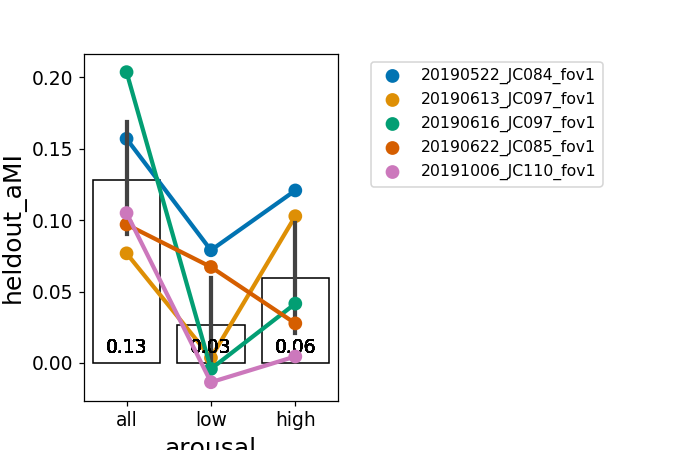

In [88]:
fig, ax = pl.subplots(figsize=(6,4), dpi=dpi)
sns.pointplot(x='arousal', y=metric, hue='datakey', data=m_df, ax=ax, palette='colorblind',
             s=10)
sns.barplot(x='arousal', y=metric, data=m_df, ax=ax, 
            edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')
ax.legend(bbox_to_anchor=(1.1, 1))

pl.subplots_adjust(right=0.5)

<IPython.core.display.Javascript object>


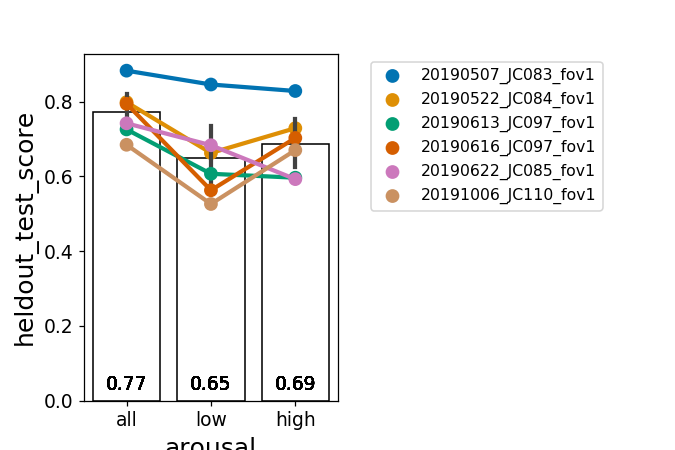

In [305]:
fig, ax = pl.subplots(figsize=(6,4), dpi=dpi)
sns.pointplot(x='arousal', y=metric, hue='datakey', data=m_df, ax=ax, palette='colorblind',
             s=10)
sns.barplot(x='arousal', y=metric, data=m_df, ax=ax, 
            edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')
ax.legend(bbox_to_anchor=(1.1, 1))

pl.subplots_adjust(right=0.5)

<IPython.core.display.Javascript object>


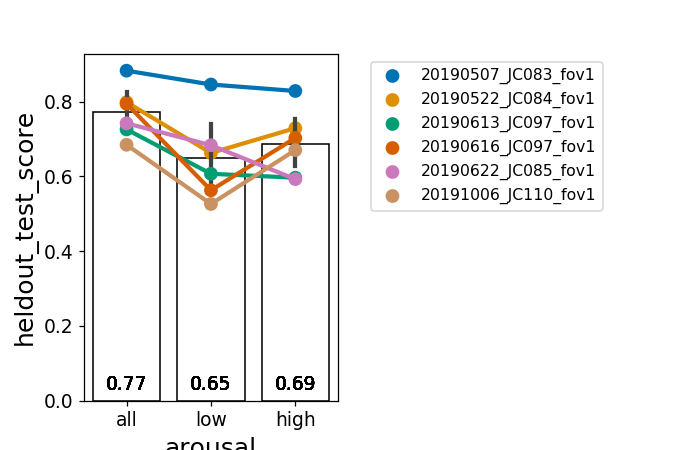

In [306]:
fig, ax = pl.subplots(figsize=(6,4), dpi=dpi)
sns.pointplot(x='arousal', y=metric, hue='datakey', data=m_df, ax=ax, palette='colorblind',
             s=10)
sns.barplot(x='arousal', y=metric, data=m_df, ax=ax, 
            edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')
ax.legend(bbox_to_anchor=(1.1, 1))

pl.subplots_adjust(right=0.5)

<IPython.core.display.Javascript object>


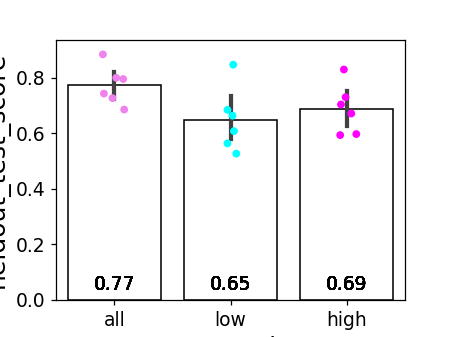

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
dtype: object

In [307]:
pupil_colors={'all': 'violet', 'low': 'aqua', 'high': 'magenta'}
fig, ax = pl.subplots(figsize=(4,3), dpi=dpi)
sns.stripplot(x='arousal', y=metric, data=m_df, ax=ax, palette=pupil_colors)
sns.barplot(x='arousal', y=metric, data=m_df, ax=ax, 
            edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')


In [293]:
multi_comp_test='fdr_bh'
# Annotate w stats
print("********* [%s|%s] *********" % (experiment, metric))
#y_loc = 16 if fov_means else 23
statresults = aggr.do_mannwhitney(m_df, metric=metric, multi_comp_test=multi_comp_test)
aggr.annotate_stats_areas(statresults, ax) #, y_loc=y_loc, offset=1)


********* [blobs|heldout_aMI] *********


KeyError: 'visual_area'

# Load RF data

In [89]:
from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.rois.utils import load_roi_coords

In [91]:
reliable_only = True
#rfs_filter_by = None # Get all # match <EXP> datasets # 'drop_repeats'
rf_fit_thr = 0.05
fit_desc = fitrf.get_fit_desc(response_type=response_type)
reliable_str = 'reliable' if reliable_only else ''
rf_str = 'match%s_%s' % (experiment, reliable_str)
print(rf_str)


#### Get non-repeated FOV datasets
rf_dsets = sdata_exp[(sdata_exp['datakey'].isin(stim_datakeys))
                     & (sdata_exp['experiment'].isin(['rfs', 'rfs10']))].copy()
rf_dpaths, no_fits = rfutils.get_fit_dpaths(rf_dsets, traceid=traceid, fit_desc=fit_desc)
print("%i with no fits" % len(no_fits))

rfdf = rfutils.aggregate_rf_data(rf_dpaths, reliable_only=reliable_only, fit_desc=fit_desc,
                                            traceid=traceid, verbose=False)
rfdf = rfdf.reset_index(drop=True)

matchblobs_reliable
N dpaths: 31, N unfit: 0
N datasets included: 31, N sessions excluded: 4
0 with no fits


#### Get position info

In [ ]:
#if get_positions:
print("Calculating RF coord conversions...")
pos_params = ['fov_xpos', 'fov_xpos_pix', 'fov_ypos', 'fov_ypos_pix', 'ml_pos','ap_pos']
for p in pos_params:
    rfdf[p] = ''
p_list=[]
for (animalid, session, fovnum), g in rfdf.groupby(['animalid', 'session', 'fovnum']):
    fcoords = load_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovnum, 
                              traceid=traceid, create_new=False)

    for ei, e_df in g.groupby(['experiment']):
        cell_ids = e_df['cell'].unique()
        p_ = fcoords['roi_positions'].loc[cell_ids]
        for p in pos_params:
            rfdf[p][e_df.index] = p_[p].values
# with open(df_fpath, 'wb') as f:
#     pkl.dump(expdf, f, protocol=pkl.HIGHEST_PROTOCOL)

In [92]:
rfdf.groupby(['datakey']).count()

,r2,fwhm_x,fwhm_y,theta,x0,y0,animalid,cell,experiment,fovnum,...,visual_area,std_x,std_y,fwhm_avg,std_avg,area,fx,fy,ratio_xy,theta_c
datakey,,,,,,,,,,,,,,,,,,,,,
20190420_JC076_fov1,36,36,36,36,36,36,36,36,36,36,...,36,36,36,36,36,36,36,36,36,36
20190430_JC078_fov1,36,36,36,36,36,36,36,36,36,36,...,36,36,36,36,36,36,36,36,36,36
20190502_JC076_fov1,19,19,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19
20190504_JC078_fov1,13,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,13
20190506_JC080_fov1,32,32,32,32,32,32,32,32,32,32,...,32,32,32,32,32,32,32,32,32,32
20190507_JC083_fov1,56,56,56,56,56,56,56,56,56,56,...,56,56,56,56,56,56,56,56,56,56
20190508_JC083_fov1,70,70,70,70,70,70,70,70,70,70,...,70,70,70,70,70,70,70,70,70,70
20190512_JC083_fov1,51,51,51,51,51,51,51,51,51,51,...,51,51,51,51,51,51,51,51,51,51
20190522_JC084_fov1,130,130,130,130,130,130,130,130,130,130,...,130,130,130,130,130,130,130,130,130,130


#### Select subset of RF data

In [93]:
r_list=[]
for datakey, expdf in dsets.groupby(['datakey']):
    # Get active blob cells
    exp_rids = sorted([r for r in MEANS[datakey].columns if putils.isnumber(r)])
    #exp_rids = sorted(np.union1d(expdf['row'].unique(), expdf['col'].unique())) 
    
    # Get current fov's RFs
    rdf = rfdf[rfdf['datakey']==datakey].copy()
    if len(rdf)==0:
        print("--- no RF! %s" % datakey)
        continue
    
    # If have both rfs/rfs10, pick the best one
    if len(rdf['experiment'].unique())>1:
        rf_rids = rdf[rdf['experiment']=='rfs']['cell'].unique()
        rf10_rids = rdf[rdf['experiment']=='rfs10']['cell'].unique()
        same_as_rfs = np.intersect1d(rf_rids, exp_rids)
        same_as_rfs10 = np.intersect1d(rf10_rids, exp_rids)
        rfname = 'rfs' if len(same_as_rfs) > len(same_as_rfs10) else 'rfs10'
        print("(%s) Selecting %s, overlappig rfs, %i | rfs10, %i (of %i cells)" 
              % (datakey, rfname, len(same_as_rfs), len(same_as_rfs10), len(exp_rids)))
        r_list.append(rdf[rdf['experiment']==rfname])
    else:
        r_list.append(rdf)
RFs = pd.concat(r_list, axis=0)


(20190602_JC091_fov1) Selecting rfs10, overlappig rfs, 33 | rfs10, 59 (of 241 cells)
(20190613_JC097_fov1) Selecting rfs10, overlappig rfs, 61 | rfs10, 88 (of 166 cells)
(20190616_JC097_fov1) Selecting rfs10, overlappig rfs, 98 | rfs10, 119 (of 296 cells)
(20190622_JC085_fov1) Selecting rfs10, overlappig rfs, 26 | rfs10, 97 (of 203 cells)
(20191006_JC110_fov1) Selecting rfs10, overlappig rfs, 46 | rfs10, 72 (of 217 cells)


## Calculate overlap with stimulus (all RFs)

In [71]:
# rf_fit_params = ['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']
# n_dks = len(RFs['datakey'].unique())

# o_list=[]
# for di, ((visual_area, animalid, session, fovnum, datakey), g) in enumerate(RFs.groupby(['visual_area', 'animalid', 'session', 'fovnum', 'datakey'])):
#     if di%10==0:
#         print("... %i of %i" % (int(di+1), n_dks))
        
#     # convert RF fit params to polygon
#     g.index = g['cell'].values
#     rf_polys = rfutils.rfs_to_polys(g[rf_fit_params])

#     # Get all pairwise overlaps (% of smaller ellipse that overlaps larger ellipse)
#     pair_ixs = list(itertools.combinations(np.arange(0, len(rf_polys)), 2))
#     overlaps = pd.concat([rfutils.get_proportion_overlap(rf_polys[p1], rf_polys[p2]) for (p1, p2) in pair_ixs], axis=0)
#     metadict={'visual_area': visual_area, 'animalid': animalid, 
#               'session': session, 'fovnum': fovnum, 'datakey': datakey}
#     o_ = putils.add_meta_to_df(overlaps, metadict)
#     o_list.append(o_)

# overlaps = pd.concat(o_list, axis=0).reset_index(drop=True)

... 1 of 22
... 11 of 22
... 21 of 22


In [95]:
rf_fit_params = ['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']

o_list=[]
for (visual_area, animalid, session, fovnum, datakey), g in RFs.groupby(['visual_area', 'animalid', 'session', 'fovnum', 'datakey']):

    # Convert RF fit params to polygon
    g.index = g['cell'].values
    rf_polys = rfutils.rfs_to_polys(g[rf_fit_params])

    # Get stimulus info
    S = util.Session(animalid, session, 'FOV%i_zoom2p0x' % fovnum)
    stim_xpos, stim_ypos = S.get_stimulus_coordinates(experiments=[experiment])
    stim_sizes = S.get_stimulus_sizes(size_tested=[experiment])

    # Convert stimuli to polyon bounding boxes
    stim_polys = [(blob_sz, rfutils.stimsize_poly(blob_sz, xpos=stim_xpos, ypos=stim_ypos)) \
                  for blob_sz in stim_sizes[experiment]]
    
    # Get all pairwise overlaps (% of smaller ellipse that overlaps larger ellipse)
    overlaps = pd.concat([rfutils.get_proportion_overlap(rf_poly, stim_poly) \
                for stim_poly in stim_polys for rf_poly in rf_polys]).rename(columns={'row': 'cell', 'col': 'stim_size'})
    metadict={'visual_area': visual_area, 'animalid': animalid, 
              'session': session, 'fovnum': fovnum, 'datakey': datakey}
    o_ = putils.add_meta_to_df(overlaps, metadict)
    o_list.append(o_)

stim_overlaps = pd.concat(o_list, axis=0).reset_index(drop=True)

Creating session object [JC090|20190605|FOV1_zoom2p0x]
... found 1 anatomical runs.
Creating blobs object [JC090|20190605|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Stimuli presented at coords: (15, 0)
Creating blobs object [JC090|20190605|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Creating session object [JC091|20190602|FOV1_zoom2p0x]
... found 1 anatomical runs.
Creating blobs object [JC091|20190602|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Stimuli presented at coords: (20, -8)
Creating blobs object [JC091|20190602|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Creating session object [JC091|20190606|FOV1_zoom2p0x]
... found 1 anatomical runs.
Creating blobs object [JC091|20190606|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Stimuli presented at coords: (20, -8)
Creating blobs object [JC091|20190606|FOV1_zoom2p0x|tra

In [96]:
d_list = []
for (visual_area, datakey), g in stim_overlaps.groupby(['visual_area', 'datakey']):
    if datakey not in MEANS.keys():
        print("No <%s> for RF key: %s" % (experiment, datakey))
        continue
        
    # Get EXPERIMENT responsive cells
    exp_rids = [r for r in MEANS[datakey].columns if putils.isnumber(r)]
    
    # Get RF fit cells
    rf_rids = sorted(g['cell'].unique())
    
    # Get cells in common
    common_rids = np.intersect1d(exp_rids, rf_rids)
    print("[%s] %s, %i cells" % (visual_area, datakey, len(common_rids)))
    
    d_list.append(g[g['cell'].isin(common_rids)].copy())
    
has_blobs = pd.concat(d_list, axis=0)
print(has_blobs.shape)

[Li] 20190602_JC091_fov1, 59 cells
[Li] 20190605_JC090_fov1, 9 cells
[Li] 20190606_JC091_fov1, 26 cells
[Li] 20190609_JC099_fov1, 22 cells
[Li] 20190617_JC099_fov1, 4 cells
[Li] 20191018_JC113_fov1, 6 cells
[Li] 20191105_JC117_fov1, 0 cells
[Li] 20191111_JC120_fov1, 1 cells
[Lm] 20190430_JC078_fov1, 31 cells
[Lm] 20190504_JC078_fov1, 10 cells
[Lm] 20190506_JC080_fov1, 31 cells
[Lm] 20190508_JC083_fov1, 61 cells
[Lm] 20190512_JC083_fov1, 39 cells
[Lm] 20190525_JC084_fov1, 36 cells
[Lm] 20190627_JC091_fov1, 6 cells
[V1] 20190420_JC076_fov1, 30 cells
[V1] 20190507_JC083_fov1, 55 cells
[V1] 20190522_JC084_fov1, 107 cells
[V1] 20190613_JC097_fov1, 88 cells
[V1] 20190616_JC097_fov1, 119 cells
[V1] 20190622_JC085_fov1, 97 cells
[V1] 20191006_JC110_fov1, 72 cells
(4545, 9)


In [98]:
overlap_thr = 0.8
has_blobs[has_blobs['perc_overlap']>=overlap_thr][['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()

,datakey,cell
visual_area,,
Li,113,113
Lm,180,180
V1,566,566


In [99]:
curr_min_pass = has_blobs[has_blobs['perc_overlap']>=overlap_thr][['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()['cell'].min()
print("Min N pass: %i (overlap thr=%.2f)" % (curr_min_pass, overlap_thr))

Min N pass: 113 (overlap thr=0.80)


In [102]:
overlap_thr=0.8
n_iterations=50
NCELLS =  60
min_ncells=10

#for overlap_thr, NCELLS in ncells_dict.items():
print("-------- Overlap: %.2f --------" % overlap_thr)
# Get list of eligible cells from all FOVs
globaldf = filter_rois(has_blobs[has_blobs['datakey'].isin(stim_datakeys)], overlap_thr=overlap_thr) 



-------- Overlap: 0.80 --------
('V1', 566)
('Lm', 180)
('Li', 113)


In [103]:
SDF={}
for datakey, g in globaldf.groupby(['datakey']):
    session, animalid, fov_ = datakey.split('_')
    fovnum = int(fov_[3:])
    obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
    sdf = obj.get_stimuli()
    SDF[datakey] = sdf

Creating blobs object [JC076|20190420|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Creating blobs object [JC078|20190430|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Creating blobs object [JC078|20190504|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Creating blobs object [JC080|20190506|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Creating blobs object [JC083|20190507|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Creating blobs object [JC083|20190508|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Creating blobs object [JC083|20190512|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Creating blobs object [JC084|20190522|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Creating blobs object [JC084|20190525|FOV1_zoom2p0x|traces001]
... getti

In [104]:
for k, d in SDF.items():
    if len(np.where(sdf['morphlevel']!=d['morphlevel'])[0]) > 0:
        print(k)
    if len(np.where(sdf['size']!=d['size'])[0]) > 0:
        print(k)

In [105]:
overlap_thr=0.8
pass_dsets = has_blobs[(has_blobs['perc_overlap']>=overlap_thr)].copy()
pass_dsets.groupby(['visual_area', 'datakey']).count()



area_overlap  stim_size  perc_overlap  cell  \
visual_area datakey                                                            
Li          20190602_JC091_fov1           248        248           248   248   
            20190605_JC090_fov1            26         26            26    26   
            20190606_JC091_fov1            76         76            76    76   
            20190609_JC099_fov1            85         85            85    85   
            20190617_JC099_fov1             3          3             3     3   
            20191018_JC113_fov1            21         21            21    21   
            20191111_JC120_fov1             2          2             2     2   
Lm          20190430_JC078_fov1            70         70            70    70   
            20190504_JC078_fov1            17         17            17    17   
            20190506_JC080_fov1           106        106           106   106   
            20190508_JC083_fov1           181        181           181   181   
            20190512_JC083_fov1           111        111           111   111   
            20190525_JC084_fov1           102        102           102   102   
            20190627_JC091_fov1            10         10            10    10   
V1          20190420_JC076_fov1           107        107           107   107   
            20190507_JC083_fov1           232        232           232   232   
            20190522_JC084_fov1           415        415           415   415   
            20190613_JC097_fov1           325        325           325   325   
            20190616_JC097_fov1           487        487           487   487   
            20190622_JC085_fov1           434        434           434   434   
            20191006_JC110_fov1           325        325           325   325   

                                 session  fovnum  animalid  
visual_area datakey                                         
Li          20190602_JC091_fov1      248     248       248  
            20190605_JC090_fov1       26      26        26  
            20190606_JC091_fov1       76      76        76  
            20190609_JC099_fov1       85      85        85  
            20190617_JC099_fov1        3       3         3  
            20191018_JC113_fov1       21      21        21  
            20191111_JC120_fov1        2       2         2  
Lm          20190430_JC078_fov1       70      70        70  
            20190504_JC078_fov1       17      17        17  
            20190506_JC080_fov1      106     106       106  
            20190508_JC083_fov1      181     181       181  
            20190512_JC083_fov1      111     111       111  
            20190525_JC084_fov1      102     102       102  
            20190627_JC091_fov1       10      10        10  
V1          20190420_JC076_fov1      107     107       107  
            20190507_JC083_fov1      232     232       232  
            20190522_JC084_fov1      415     415       415  
            20190613_JC097_fov1      325     325       325  
            20190616_JC097_fov1      487     487       487  
            20190622_JC085_fov1      434     434       434  
            20191006_JC110_fov1      325     325       325

In [106]:
pass_dsets

,area_overlap,stim_size,perc_overlap,cell,session,datakey,visual_area,fovnum,animalid
85,100.000000,10,1.000000,15,20190602,20190602_JC091_fov1,Li,1,JC091
86,100.000000,10,1.000000,16,20190602,20190602_JC091_fov1,Li,1,JC091
87,100.000000,10,1.000000,22,20190602,20190602_JC091_fov1,Li,1,JC091
88,100.000000,10,1.000000,23,20190602,20190602_JC091_fov1,Li,1,JC091
92,100.000000,10,1.000000,27,20190602,20190602_JC091_fov1,Li,1,JC091
93,100.000000,10,1.000000,29,20190602,20190602_JC091_fov1,Li,1,JC091
95,100.000000,10,1.000000,33,20190602,20190602_JC091_fov1,Li,1,JC091
97,100.000000,10,1.000000,37,20190602,20190602_JC091_fov1,Li,1,JC091
98,100.000000,10,1.000000,38,20190602,20190602_JC091_fov1,Li,1,JC091
99,100.000000,10,1.000000,39,20190602,20190602_JC091_fov1,Li,1,JC091


In [107]:
MEANS[datakey].shape, datakey

((1500, 27), '20191111_JC120_fov1')

In [ ]:
metric = 'heldout_test_score'

d_list=[]; d_list_chance=[]; dkeys=[]; vkeys=[];
lo_list=[]; lo_list_chance=[]; 
hi_list=[]; hi_list_chance=[]; 

n_datakeys = len(pass_dsets['datakey'].unique())
for di, ((visual_area, datakey), ds) in enumerate(pass_dsets.groupby(['visual_area', 'datakey'])):
    if datakey in skip:
        continue
    if len(ds) < min_ncells:
        print("(%s) Too few pass: %i"% (datakey, len(ds)))
        continue
    
    if di % 5 == 0:
        print("%i of %i datakeys" % (int(di+1), n_datakeys))
    
    print("**** [%s] %s *****" % (visual_area, datakey))
    #neuraldf = MEANS[datakey].copy() 
    config_list = MEANS[datakey]['config']
    roi_list = ds['cell'].unique()
    ncells_t = MEANS[datakey].shape[1]-1
    print("... %i of %i cells" % (len(roi_list), ncells_t))
    neuraldf = MEANS[datakey][roi_list].copy() 
    neuraldf['config'] = config_list
    sdf = SDF[datakey].copy()
    
    
    # ------ PUPIL --------------------------------------------------
    pupiltraces = PUPIL['%s_%s' % (datakey, experiment)].copy()

    #### Resample pupil
    desired_nframes = 60 #len(out_ixs) # 60
    binned_pupil = resample_pupil_traces(pupiltraces, in_rate=20.0, out_rate=new_framerate, 
                                         min_nframes=desired_nframes)
    trials_ = sorted(pupiltraces['trial'].unique())
    frames_ = np.arange(0, desired_nframes)
#     binned_pupil = resample_pupil_traces(pupiltraces, in_rate=20.0, out_rate=new_framerate)
#     # binned_trialmat.shape # Ntrials # Nframes
#     trials_ = sorted(pupiltraces['trial'].unique())
#     new_nframes_per_trial = binned_pupil.shape[0]/float(len(trials_))
#     frames_ = np.arange(0, new_nframes_per_trial)
    pupil_trialmat = pd.DataFrame(np.vstack([p['pupil'].values for trial, p in binned_pupil.groupby(['trial'])]),
                                  index=trials_, columns=frames_)
                                  #index=binned_trialmat.index, columns=binned_trialmat.columns)
    pupil_r = pupil_trialmat.T.unstack().reset_index().rename(columns={'level_0': 'trial', 
                                                                   'level_1': 'frame',
                                                                   0: 'pupil'})
    pupildf = pd.concat([g.mean(axis=0) for t, g in pupil_r.groupby(['trial'])], axis=1).T
    
    # ------ Split trials by quantiles ---------------------------------
    pupil_quantiles = pupildf.pupil.quantile([0.25,0.5,0.75])
    low_pupil_thr = pupil_quantiles[0.25]
    high_pupil_thr = pupil_quantiles[0.75]
    pupil_low = pupildf[pupildf['pupil']<=low_pupil_thr].copy()
    pupil_high = pupildf[pupildf['pupil']>=high_pupil_thr].copy()

    # Get trial indices of low/high pupil 
    low_trial_ixs = sorted(pupil_low['trial'].unique())
    high_trial_ixs = sorted(pupil_high['trial'].unique())
    
    # Fit all
    curr_data = neuraldf.copy()
    df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)
    print("all: %.2f (chance=%.2f)" % (df.mean()[metric], df_chance.mean()[metric]))
    d_list.append(df.mean(axis=0).T)
    d_list_chance.append(df_chance.mean(axis=0).T)
    
    # Fit LOW
    curr_data = neuraldf.loc[low_trial_ixs].copy()
    df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)
    print("low: %.2f (chance=%.2f)" % (df.mean()[metric], df_chance.mean()[metric]))
    lo_list.append(df.mean(axis=0).T)
    lo_list_chance.append(df_chance.mean(axis=0).T)
    
    # Fit LOW
    curr_data = neuraldf.loc[high_trial_ixs].copy()
    df, df_chance = fit_svm(curr_data, sdf, m0=m0, m100=m100, C_value=C_value, n_iterations=n_iterations)
    print("high: %.2f (chance=%.2f)" % (df.mean()[metric], df_chance.mean()[metric]))
    hi_list.append(df.mean(axis=0).T)
    hi_list_chance.append(df_chance.mean(axis=0).T)
    
    dkeys.append(datakey)
    vkeys.append(visual_area)

1 of 21 datakeys
**** [Li] 20190602_JC091_fov1 *****
... 57 of 241 cells
all: 0.74 (chance=0.49)
low: 0.73 (chance=0.53)
high: 0.73 (chance=0.44)
**** [Li] 20190605_JC090_fov1 *****
... 8 of 129 cells
all: 0.55 (chance=0.49)
low: 0.62 (chance=0.52)
high: 0.48 (chance=0.47)
**** [Li] 20190606_JC091_fov1 *****
... 21 of 136 cells
all: 0.58 (chance=0.49)
low: 0.42 (chance=0.52)
high: 0.41 (chance=0.54)
**** [Li] 20190609_JC099_fov1 *****
... 20 of 78 cells
all: 0.62 (chance=0.49)
low: 0.53 (chance=0.48)
high: 0.44 (chance=0.49)
(20190617_JC099_fov1) Too few pass: 3
6 of 21 datakeys
**** [Li] 20191018_JC113_fov1 *****
... 5 of 64 cells
all: 0.51 (chance=0.49)
low: 0.46 (chance=0.47)
high: 0.48 (chance=0.47)
(20191111_JC120_fov1) Too few pass: 2
**** [Lm] 20190430_JC078_fov1 *****
... 24 of 187 cells
all: 0.59 (chance=0.49)
low: 0.55 (chance=0.52)
high: 0.53 (chance=0.48)
**** [Lm] 20190504_JC078_fov1 *****
... 8 of 187 cells
all: 0.61 (chance=0.51)
low: 0.56 (chance=0.50)
high: 0.62 (chanc

In [197]:
print(d_list[0].shape)
full_df = pd.concat(d_list, axis=1).T
full_chance = pd.concat(d_list_chance, axis=1).T
full_df['datakey'] = dkeys
full_chance['datakey'] = dkeys
full_df['visual_area'] = vkeys
full_chance['visual_area'] = vkeys

lo_df = pd.concat(lo_list, axis=1).T
lo_chance = pd.concat(lo_list_chance, axis=1).T
lo_df['datakey'] = dkeys
lo_chance['datakey'] = dkeys
lo_df['visual_area'] = vkeys
lo_chance['visual_area'] = vkeys

hi_df = pd.concat(hi_list, axis=1).T
hi_chance = pd.concat(hi_list_chance, axis=1).T
hi_df['datakey'] = dkeys
hi_chance['datakey'] = dkeys
hi_df['visual_area'] = vkeys
hi_chance['visual_area'] = vkeys


(12,)


In [198]:
full_df.groupby(['visual_area', 'datakey']).mean().mean()

fit_time                           0.002315
heldout_MI                         0.087163
heldout_aMI                        0.115697
heldout_log2MI                     0.125749
heldout_test_score                 0.673988
score_time                         0.000655
test_accuracy                      0.655283
test_neg_mean_squared_error    -3873.245672
test_r2                           -0.380216
train_accuracy                     0.759545
train_neg_mean_squared_error   -2701.747554
train_r2                           0.037300
dtype: float64

In [199]:
m_

,all,low,high
0,0.766000,0.726000,0.727500
1,0.586061,0.545000,0.455238
2,0.594242,0.588000,0.595556
3,0.628000,0.568235,0.492941
4,0.514105,0.463704,0.538333
5,0.603333,0.474444,0.553684
6,0.576333,0.515714,0.422105
7,0.654333,0.560000,0.573333
8,0.674000,0.652941,0.407143
9,0.544000,0.555294,0.350000


In [202]:
few = [] #['20191018_JC113_fov1', '20190605_JC090_fov1']

<IPython.core.display.Javascript object>


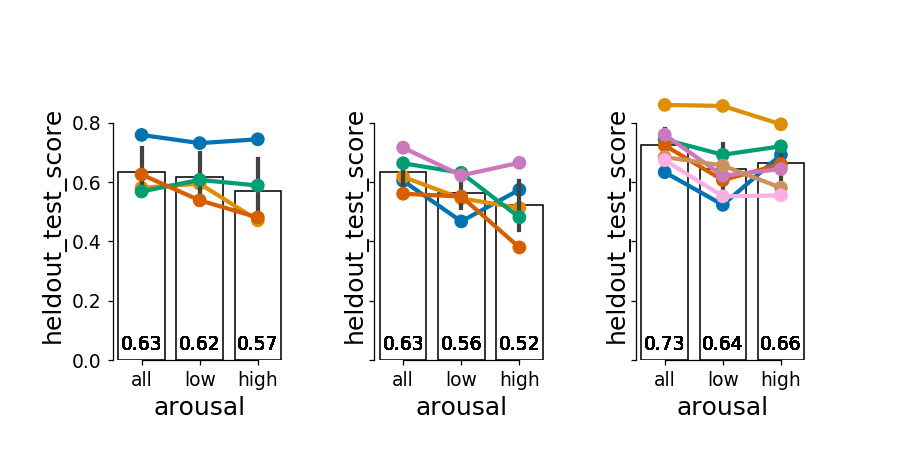

In [203]:
metric='heldout_test_score'

m_ = pd.concat([full_df[metric], lo_df[metric], hi_df[metric]], axis=1)
m_.columns = ['all', 'low', 'high']
# m_df['datakey'] = full_df['datakey']
m_df = m_.unstack().reset_index().rename(columns={'level_0': 'arousal', 'level_1': 'datakey', 0: metric})

m_df['datakey'] = [full_df.loc[i]['datakey'] for i in m_df['datakey']]
#m_df['visual_area'] = [full_df.loc[i]['visual_area'] for i in m_df['datakey']]
v_labels = pd.concat([full_df['visual_area'], lo_df['visual_area'], hi_df['visual_area']], axis=0).values
m_df['visual_area'] = v_labels

plotdf = m_df[~m_df['datakey'].isin(few)]

# plot
fig, axn = pl.subplots(1, 3, figsize=(8,4), dpi=dpi, sharex=True, sharey=True)
for ax, (arousal, a_df) in zip(axn.flat, plotdf.groupby(['visual_area'])):
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=a_df, ax=ax, palette='colorblind',
                 s=10, join=True)
    sns.barplot(x='arousal', y=metric, data=a_df, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    m_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k')
    #ax.legend(bbox_to_anchor=(1.1, 1))
    ax.legend_.remove()
pl.subplots_adjust(wspace=0.5, bottom=0.2, top=0.8)
sns.despine(trim=True)

In [101]:
def filter_rois(has_blobs, overlap_thr=0.50):
    visual_areas=['V1', 'Lm', 'Li']
    nocells=[]; notrials=[];
    global_rois = dict((v, []) for v in visual_areas)
    roi_counters = dict((v, 0) for v in visual_areas)
    roidf = []
    datakeys = dict((v, []) for v in visual_areas)
    
    for (visual_area, datakey), g in has_blobs[has_blobs['perc_overlap']>=overlap_thr].groupby(['visual_area', 'datakey']):

        roi_counter = roi_counters[visual_area]
        datakeys[visual_area].append(datakey)

        #ddf.sort_values(by='config')
        roi_list = sorted([s for s in g['cell'].unique()]) #[int(r) for r in ddf.columns if r != 'config']

        # Reindex roi ids for global
        roi_ids = [i+roi_counter for i, r in enumerate(roi_list)]
        nrs = len(roi_list)

        global_rois[visual_area].extend(roi_ids)
        roidf.append(pd.DataFrame({'roi': roi_ids,
                                   'dset_roi': roi_list,
                                   'visual_area': [visual_area for _ in np.arange(0, nrs)],
                                   'datakey': [datakey for _ in np.arange(0, nrs)]}))

        # Update global roi id counter
        roi_counters[visual_area] += len(roi_ids)

    roidf = pd.concat(roidf, axis=0) #.groupby(['visual_area']).count()
    #print("%i datasets fail all thresholds:" % len(nocells), nocells)
    for k, v in global_rois.items():
        print(k, len(v))
        
    return roidf